# Video Pipeline Reading Labelled Videos from a Directory

In this example, we will show how to read videos along with their labels using the [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) operator.
The reader returns pairs of outputs: batches of sequences and respective labels.

For more information on the [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) parameters, please look at the documentation.

## Setting Up

First let's start with the imports:

In [1]:
import os
from itertools import islice
from pathlib import Path

import nvidia.dali.experimental.dynamic as ndd

We need some video containers to process. We can use [Sintel](https://en.wikipedia.org/wiki/Sintel) trailer, which is an mp4 container containing an h.264 video and distributed under the Creative Commons license. We've split it into 5 second clips and divided the clips into labelled groups. This can be done easily with the `ffmpeg` standalone tool.

Then we can set the parameters that will be used by the reader. The `sequence_length` parameter defines how many frames we want in each sequence sample.

We can replace `video_directory` with any other directory containing labelled subdirectories and video container files recognized by **FFmpeg**.

In [2]:
batch_size = 2
sequence_length = 8
initial_prefetch_size = 11
dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
video_directory = dali_extra_dir / "db" / "video" / "sintel" / "labelled_videos"
n_iter = 6

<div class="alert alert-info">

   Note<br>

   `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.
</div>

## Reading Labelled Videos

We create a [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) instance with `file_root` pointing to the directory with labelled subdirectories:

In [3]:
reader = ndd.readers.Video(
    device="gpu",
    file_root=str(video_directory),
    sequence_length=sequence_length,
    random_shuffle=True,
    initial_fill=initial_prefetch_size,
    file_list_include_preceding_frame=True,
    seed=12345,
)

<div class="alert alert-warning">

   Caution<br>

   One important thing here is tuning `initial_fill`, which corresponds to the reader prefetch buffer initial size. Since this buffer will be filled with `initial_fill` sequences, the total number of frames can be really huge! So set it accordingly to avoid running out of memory during training.
</div>

We can now iterate over batches of video sequences and their labels. Each batch contains `batch_size` sequences and `batch_size` labels.

In [4]:
for videos, labels in islice(reader.next_epoch(batch_size=batch_size), n_iter):
    print(ndd.as_tensor(videos).shape)
    print(ndd.as_tensor(labels).shape)

(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)


(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)


## Visualizing the Results

The previous iterations seem to have yielded batches of the expected shape. But let's visualize the results to be sure.

We will use matplotlib to display the frames we obtained in the last batch.

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [6]:
def show_sequence(sequence: ndd.Tensor, label: ndd.Tensor):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.suptitle(f"label {label.item()}", fontsize=30)
        plt.imshow(sequence[j])

And now let's generate 5 batches of sequence, label pairs:

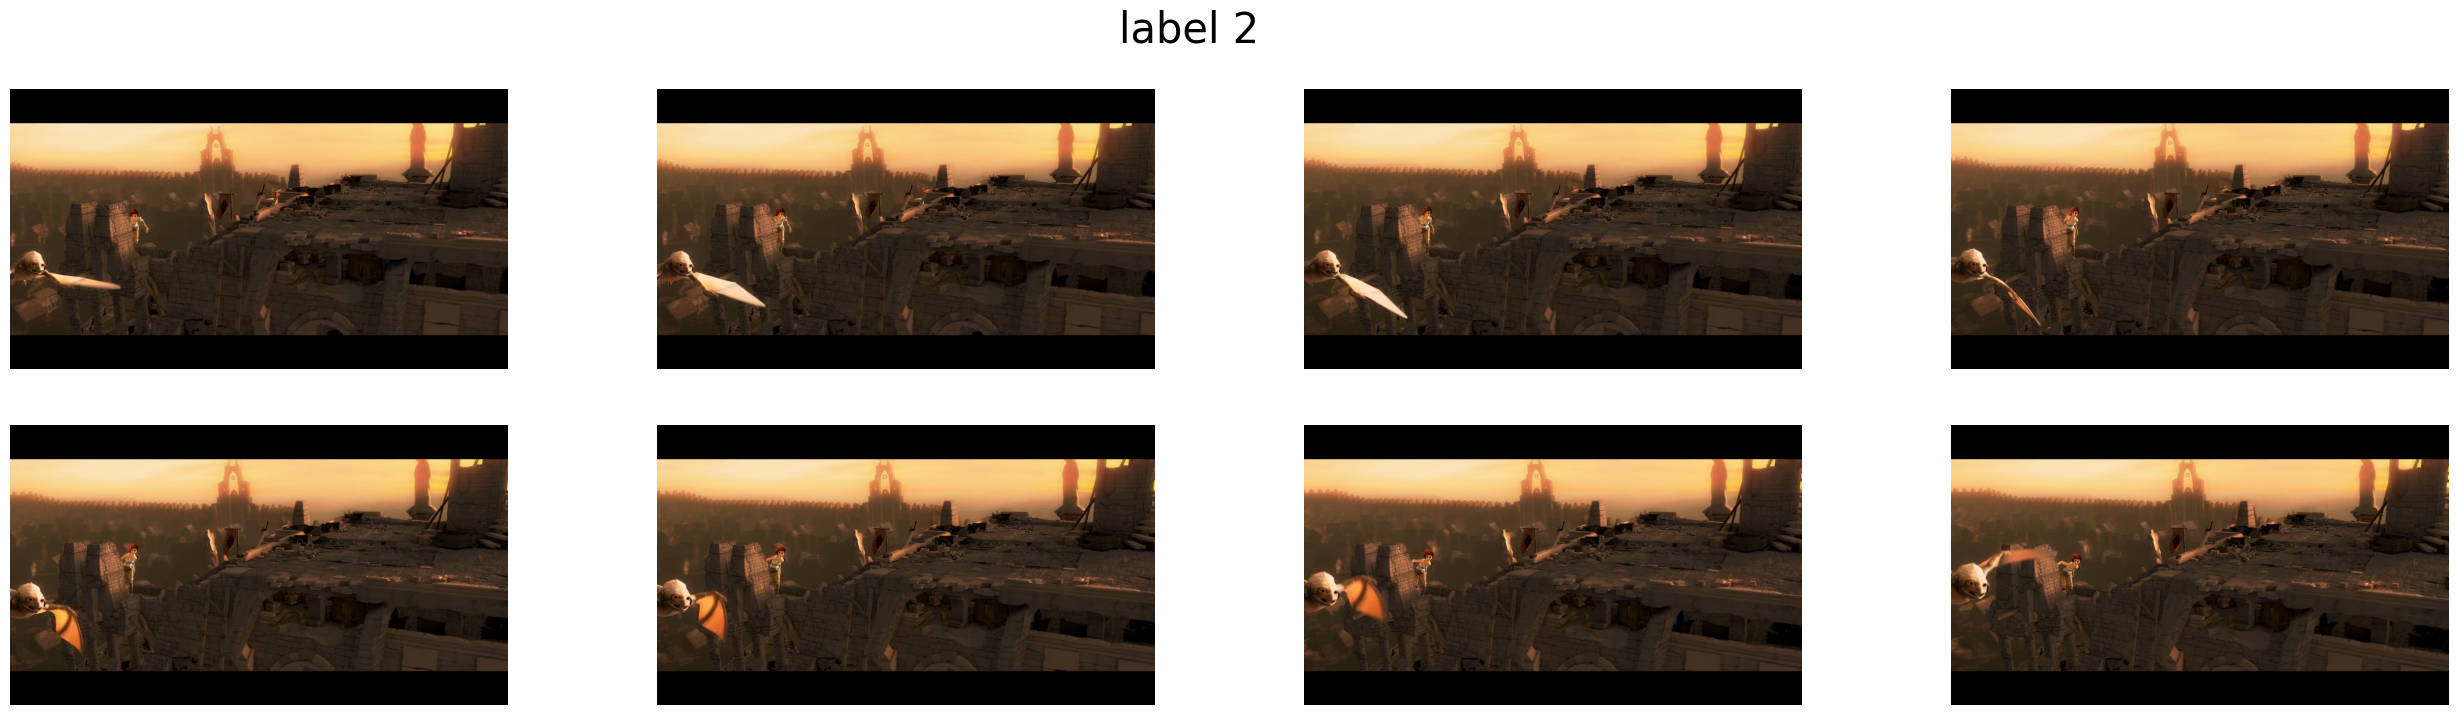

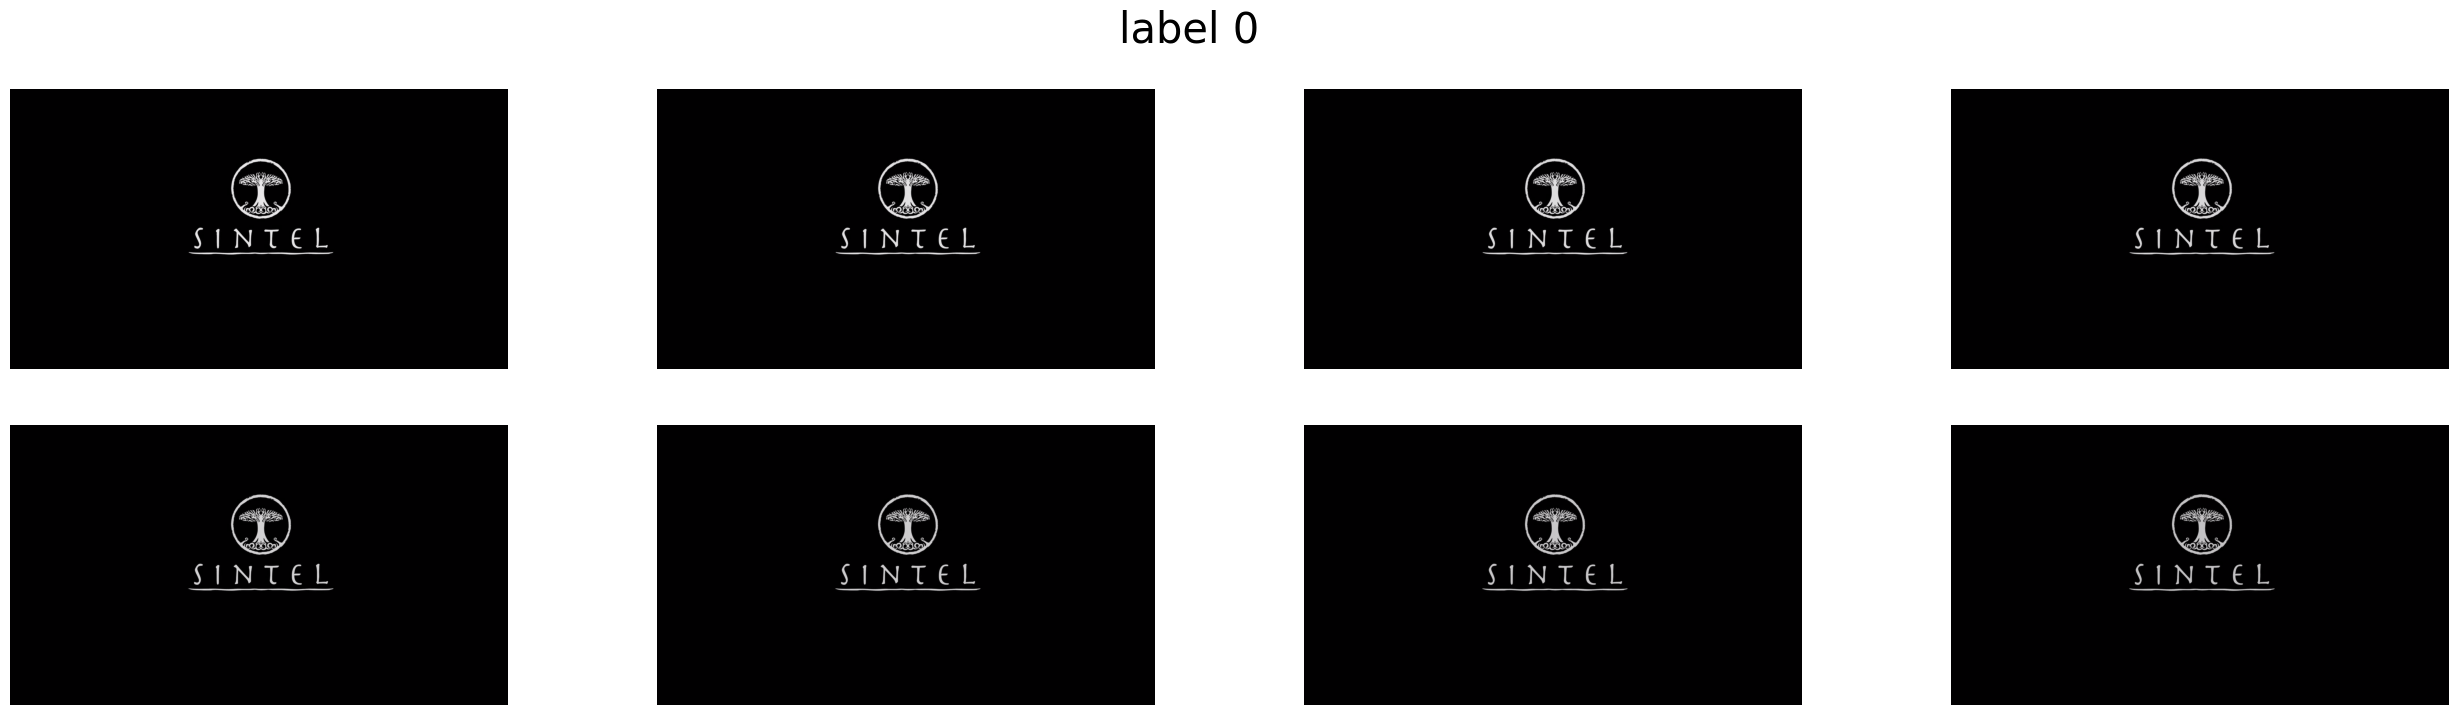

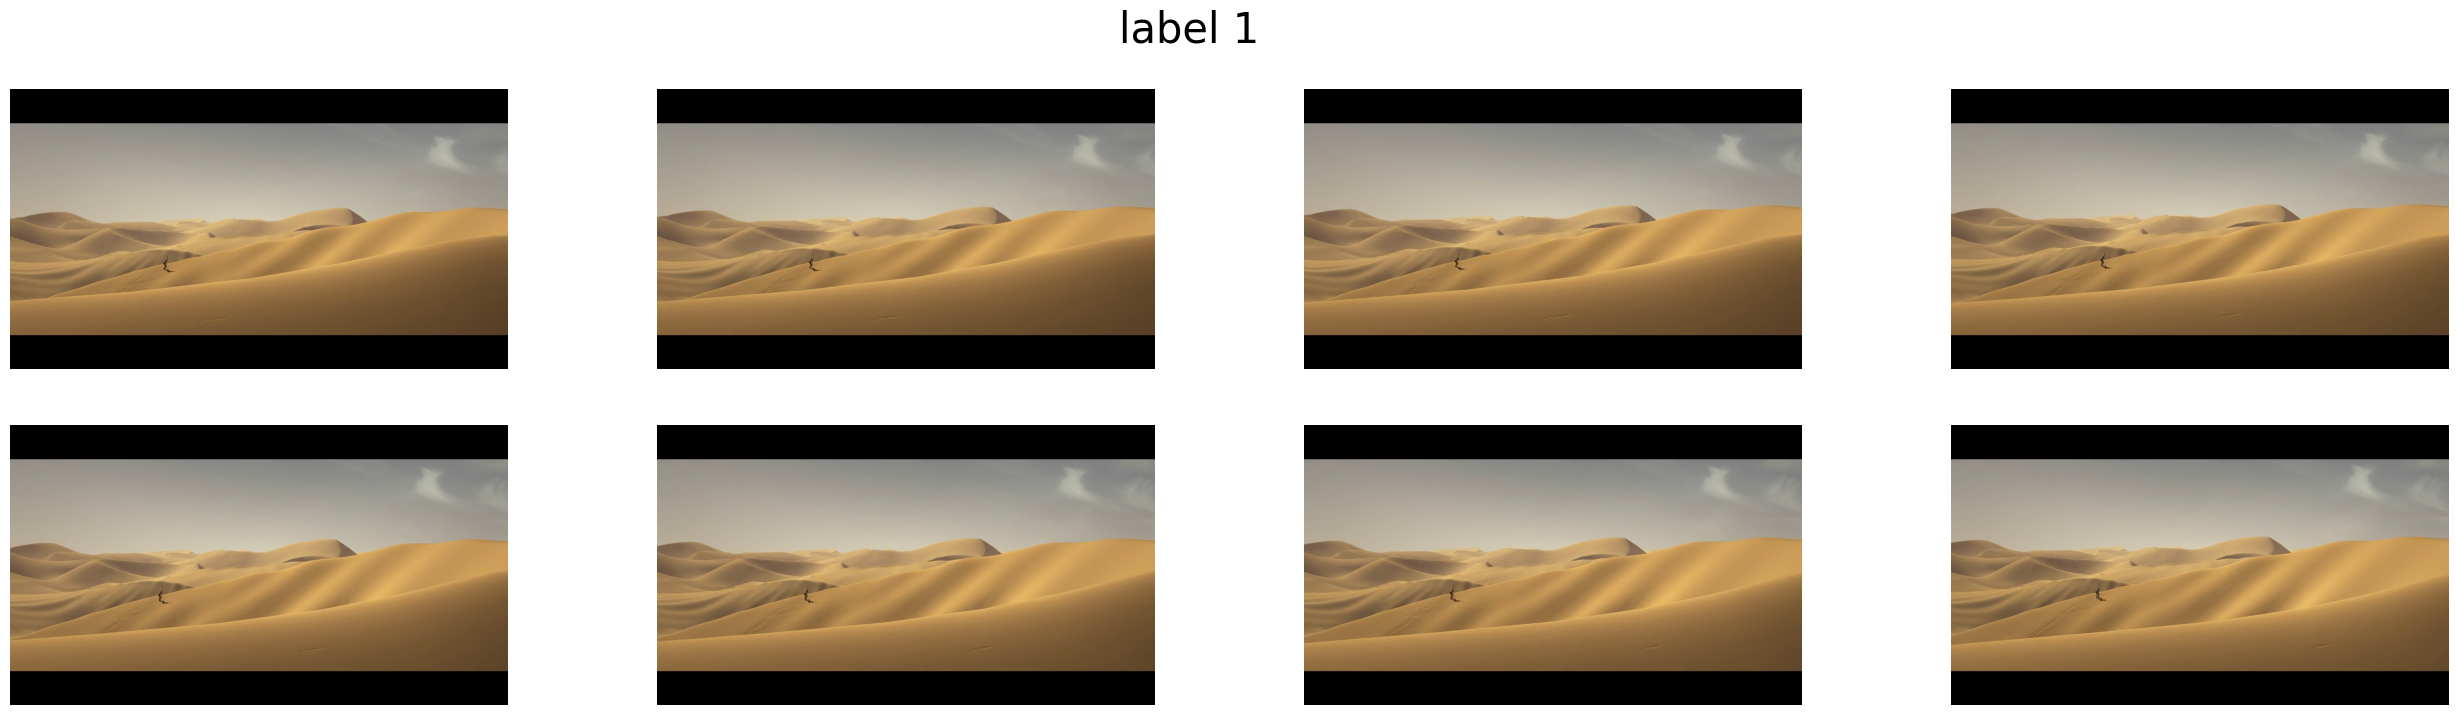

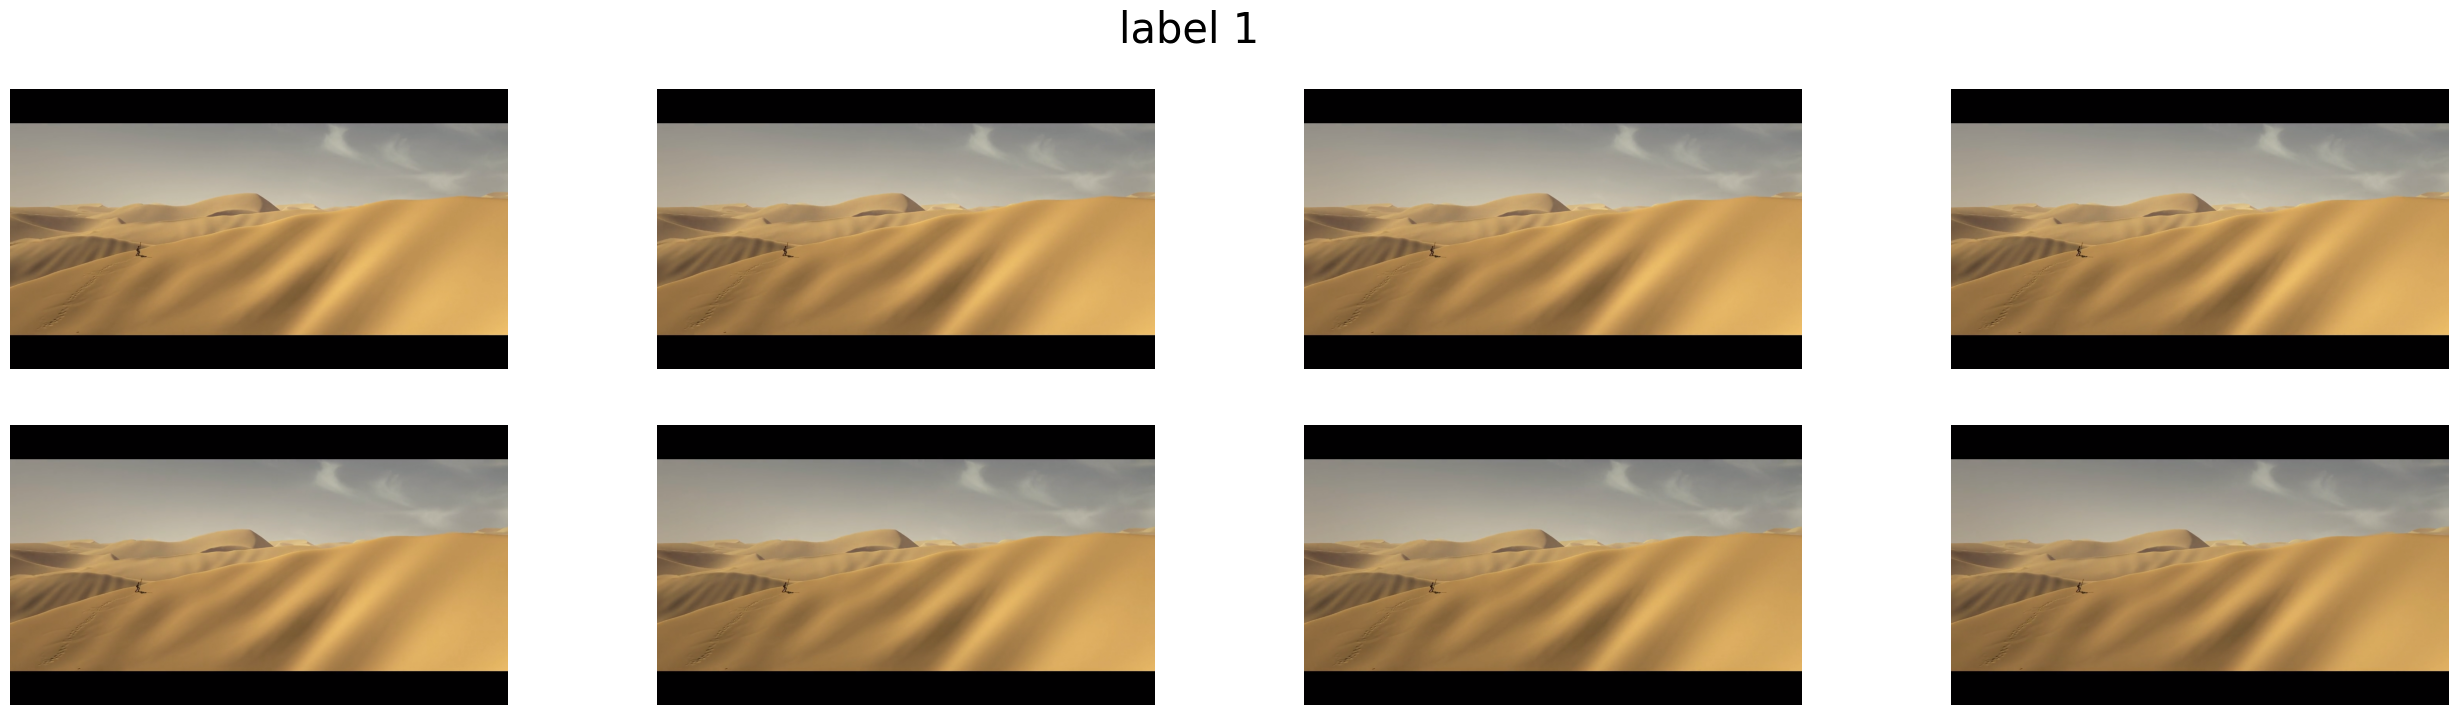

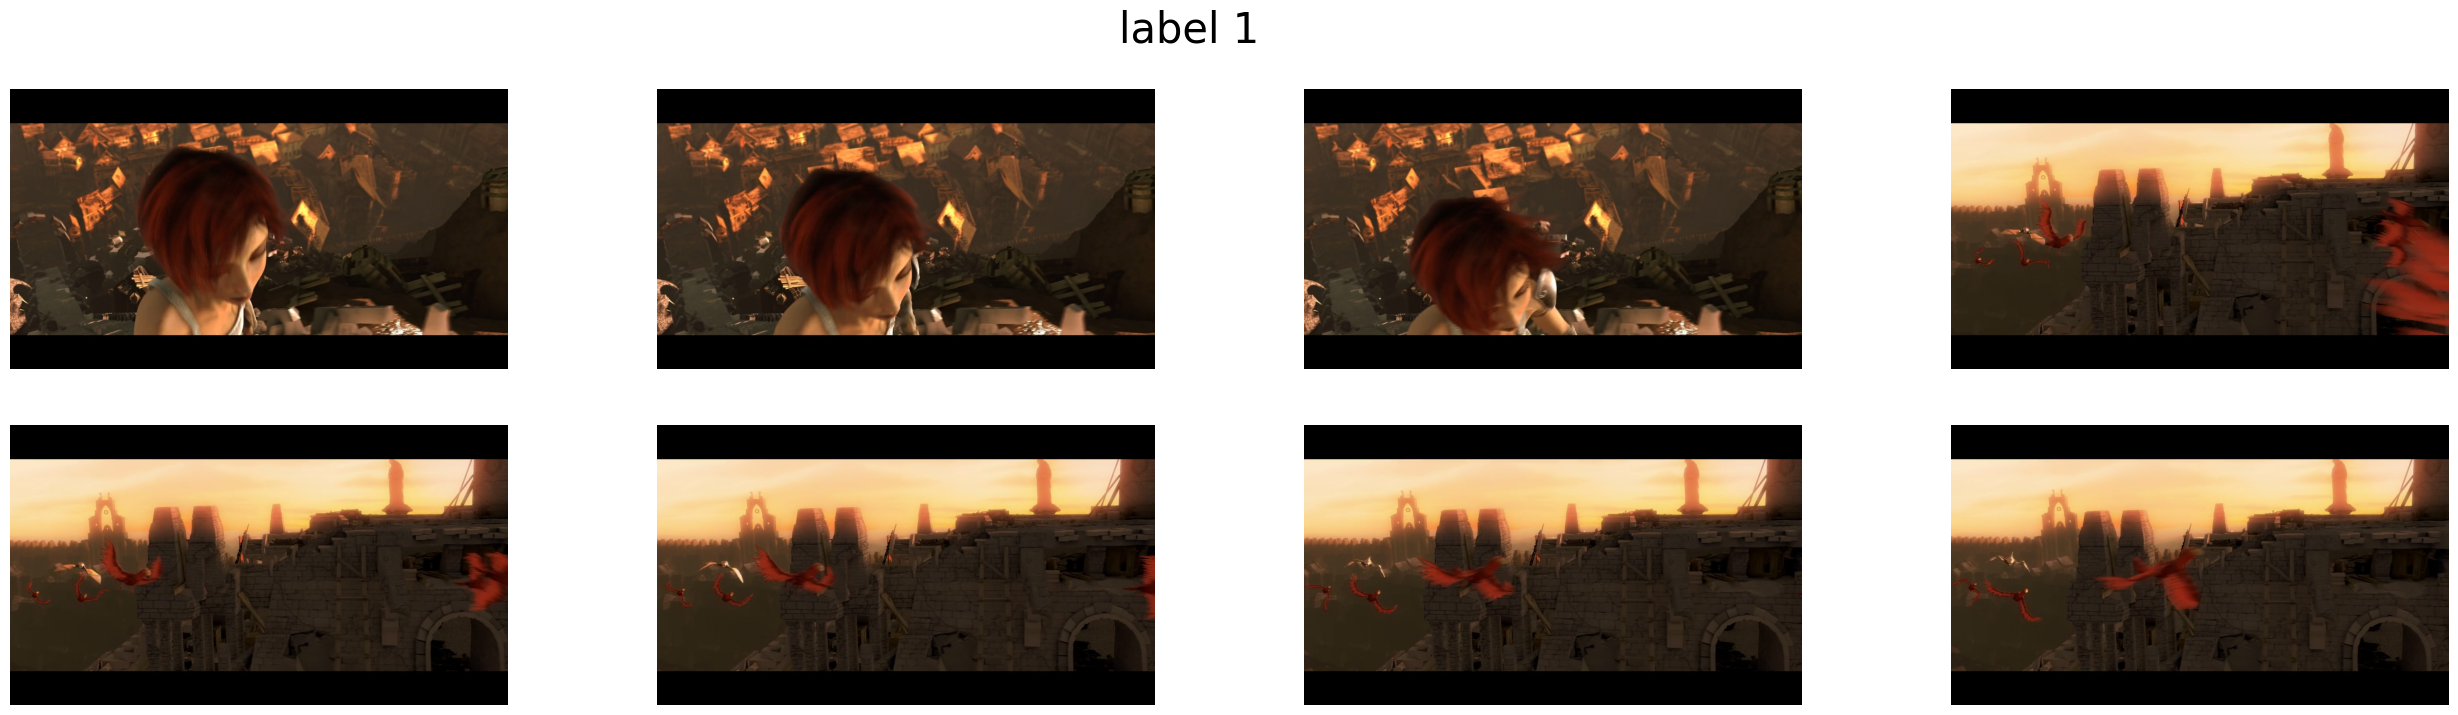

In [7]:
ITER = 5

for videos, labels in islice(reader.next_epoch(batch_size=batch_size), ITER):
    # Get the second sample from each batch
    show_sequence(videos.select(1).cpu(), labels.select(1).cpu())